<a href="https://colab.research.google.com/github/juccaicedoac03/ML_dep/blob/main/Training/ML_trainig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [1]:
!pip install -U git+https://github.com/juccaicedoac03/ML_dep.git >/dev/null

  Running command git clone -q https://github.com/juccaicedoac03/ML_dep.git /tmp/pip-req-build-0gddclzd


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from imblearn.over_sampling import SMOTE,BorderlineSMOTE
import pickle
from ML_dep.Utils import remove_duplicates,get_df_unique,timeConverter,get_scores

#Download data

In [3]:
!gdown --id 1QhadhG5go0l-pTEVrDmfIYEoZjP8ygAg ## Data train
!gdown --id 1eOdY-XCJATQFaiB94zFemJJkbZLB8aVZ ## Data test

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QhadhG5go0l-pTEVrDmfIYEoZjP8ygAg
To: /content/datase.csv
100% 9.79M/9.79M [00:01<00:00, 7.19MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1eOdY-XCJATQFaiB94zFemJJkbZLB8aVZ
To: /content/orders_test.csv
100% 2.39M/2.39M [00:00<00:00, 223MB/s]


#EDA

In [4]:
X_row = pd.read_csv('/content/datase.csv')

In [5]:
X_row

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
0,14924129,900007722,2.188069,43.430176,5500,2017-09-17T14:36:51Z,1
1,15517560,900008156,0.970423,64.589722,5200,2017-09-28T12:33:04Z,1
2,15365462,900004503,2.699022,257.006104,6700,2017-09-25T12:43:57Z,1
3,14245605,900015422,0.725768,-42.870361,3200,2017-09-05T17:17:09Z,1
4,15213594,900011745,0.750715,-34.016602,5700,2017-09-22T21:38:58Z,1
...,...,...,...,...,...,...,...
117584,15048263,900009494,0.402109,-22.629395,6200,2017-09-19T19:42:54Z,1
117585,15789217,900008201,0.374944,-4.408203,3200,2017-10-02T18:29:02Z,1
117586,15636112,900009494,2.836608,-89.113770,8050,2017-09-30T13:11:03Z,0
117587,14639888,30000253,2.724799,21.098999,3900,2017-09-12T12:33:08Z,0


In [6]:
print(X_row['order_id'].shape,np.unique(X_row['order_id']).shape)
print('There are duplicated rows!')

(117589,) (117552,)
There are duplicated rows!


##Remove duplicates

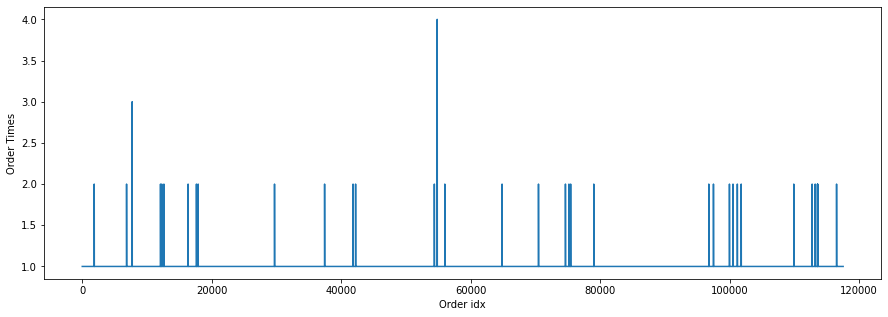

In [7]:
orders, orders_count = np.unique(X_row['order_id'],return_counts=True)

plt.figure(figsize=(15,5))
plt.plot(orders_count)
plt.ylabel('Order Times')
plt.xlabel('Order idx')
#plt.xticks(np.linspace(0,X_row.shape[0],X_row.shape[0]))
plt.show()

Remove duplicated orders

There's two options:

1. An order failed and it was retake
2. An order failed and it was canceled

we will take the latest order status.

In [8]:
X_new = get_df_unique(X_row,column_id='order_id')
X_new

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
0,14924129,900007722,2.188069,43.430176,5500,2017-09-17T14:36:51Z,1
1,15517560,900008156,0.970423,64.589722,5200,2017-09-28T12:33:04Z,1
2,15365462,900004503,2.699022,257.006104,6700,2017-09-25T12:43:57Z,1
3,14245605,900015422,0.725768,-42.870361,3200,2017-09-05T17:17:09Z,1
4,15213594,900011745,0.750715,-34.016602,5700,2017-09-22T21:38:58Z,1
...,...,...,...,...,...,...,...
116465,15836414,900009494,2.687707,-124.098389,9050,2017-10-03T19:03:06Z,1
11666,15836701,900007604,0.651611,-1.937866,9200,2017-10-03T19:30:06Z,1
65294,15886206,900010570,0.857461,-1.796753,3200,2017-10-04T19:23:08Z,1
63037,14342791,900005727,1.093874,-26.469238,3200,2017-09-07T17:43:06Z,0


In [9]:
print('Take: {}'.format(np.sum(X_new['taken']==1)),'No take: {}'.format(np.sum(X_new['taken']==0)))
print('Imbalanced classes!')

Take: 108268 No take: 9284
Imbalanced classes!


##Get preproceced data and labels

In [10]:
col_names = list(X_new.keys())
print(col_names)

['order_id', 'store_id', 'to_user_distance', 'to_user_elevation', 'total_earning', 'created_at', 'taken']


- We drop the order id because it's a unique value
- We generate new features from datetime column

In [11]:
feat_names = col_names[1:-1]

prep = timeConverter(feat_names=feat_names)
X_train = prep.fit_transform(X_new)

labels = col_names[-1]
y_train = X_new[labels]

print(X_train.shape,y_train.shape)

(117552, 6) (117552,)


In [12]:
X_train

,store_id,to_user_distance,to_user_elevation,total_earning,weekday,hour
0,900007722,2.188069,43.430176,5500,6,1436
1,900008156,0.970423,64.589722,5200,3,1233
2,900004503,2.699022,257.006104,6700,0,1243
3,900015422,0.725768,-42.870361,3200,1,1717
4,900011745,0.750715,-34.016602,5700,4,2138
...,...,...,...,...,...,...
116465,900009494,2.687707,-124.098389,9050,1,1903
11666,900007604,0.651611,-1.937866,9200,1,1930
65294,900010570,0.857461,-1.796753,3200,2,1923
63037,900005727,1.093874,-26.469238,3200,3,1743


#Training

##Applying oversample to avoid class imbalance

In [13]:
oversample = BorderlineSMOTE(random_state=123)
X_tr, y_tr = oversample.fit_resample(X_train, y_train)
print(X_tr.shape, y_tr.shape)

(216536, 6) (216536,)


In [14]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X_tr, y_tr, test_size=0.3, random_state=42)

##Training RandomForest Classifier

###Parameter tunning

In [15]:
mdl = RandomForestClassifier()
parameters = {'n_estimators':[100,200,300,400,500],
              'max_depth':[6,12,24,None]}
clf = GridSearchCV(mdl, parameters,scoring='accuracy',cv=5,n_jobs=-1)
clf.fit(X_tr,y_tr)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [6, 12, 24, None],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy')

In [16]:
clf.cv_results_

{'mean_fit_time': array([ 18.57217898,  26.41459064,  39.47523723,  51.99648895,
         65.12286158,  22.387075  ,  44.84575195,  67.9396452 ,
         90.25483317, 112.28110051,  32.89918246,  66.1466013 ,
         99.62943001, 133.48768764, 166.74682155,  34.83559628,
         68.56594572, 102.014078  , 136.87877841, 168.98465505]),
 'mean_score_time': array([0.33901048, 0.54243445, 0.8001543 , 1.06923985, 1.3223011 ,
        0.46842227, 0.93454189, 1.40174198, 1.8678946 , 2.34467773,
        0.97129598, 1.89752836, 2.82163506, 3.80813532, 4.75836887,
        1.0175983 , 2.0262044 , 3.02998443, 4.07155809, 4.85399036]),
 'mean_test_score': array([0.71021606, 0.70755731, 0.71057232, 0.70859311, 0.70956292,
        0.77896751, 0.77859146, 0.77887514, 0.77926439, 0.77961405,
        0.88917698, 0.89066139, 0.89145967, 0.89110341, 0.89149266,
        0.89610424, 0.89729177, 0.89820221, 0.89835395, 0.89851889]),
 'param_max_depth': masked_array(data=[6, 6, 6, 6, 6, 12, 12, 12, 12, 12, 2

In [17]:
clf.best_params_

{'max_depth': None, 'n_estimators': 500}

In [18]:
clf.best_score_

0.8985188850404089

###Training with best parameters

In [19]:
mdl_final = clf.best_estimator_
mdl_final.fit(X_tr, y_tr)

RandomForestClassifier(n_estimators=500)

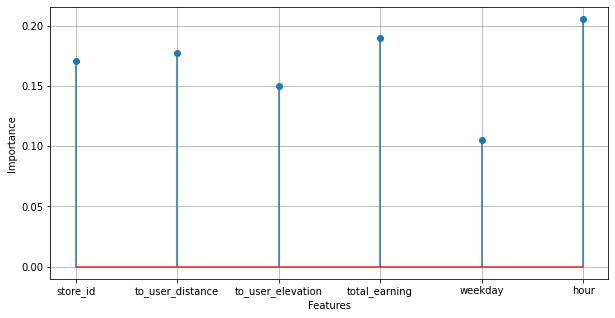

In [20]:
plt.figure(figsize=(10,5))
plt.stem(mdl_final.feature_importances_,use_line_collection=True)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(np.linspace(0,X_tr.shape[-1]-1,X_tr.shape[-1]),X_tr.keys().to_list())
plt.grid('on')
plt.show()

Save model

In [21]:
#pickle.dump(mdl_final, open('/content/RF_model.pkl', 'wb'))

###Load model

In [22]:
!gdown 1lWfMIZLNehFV65AgeJK_UjSToylPFiBi

Downloading...
From: https://drive.google.com/uc?id=1lWfMIZLNehFV65AgeJK_UjSToylPFiBi
To: /content/RF_model.pkl
100% 1.04G/1.04G [00:13<00:00, 75.9MB/s]


In [23]:
mdl_final = pickle.load( open( "/content/RF_model.pkl", "rb" ) )

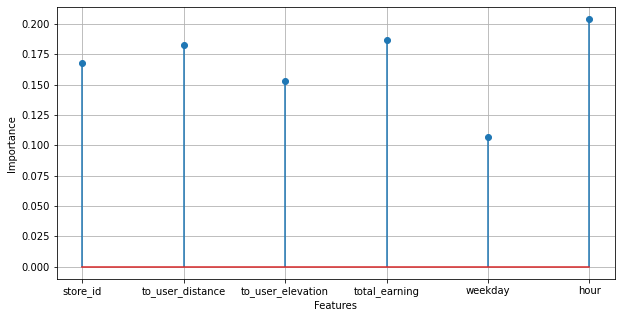

In [24]:
plt.figure(figsize=(10,5))
plt.stem(mdl_final.feature_importances_,use_line_collection=True)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(np.linspace(0,X_tr.shape[-1]-1,X_tr.shape[-1]),X_tr.keys().to_list())
plt.grid('on')
plt.show()

###Results

In [25]:
y_pred = mdl_final.predict(X_ts)

In [26]:
scores = [accuracy_score,f1_score,roc_auc_score]
pd.DataFrame(np.expand_dims(np.asarray(get_scores(y_pred,y_ts.to_numpy(),scores)),axis=0),
             columns=['Accuracy','F1-score','AUC'])

,Accuracy,F1-score,AUC
0,0.89115,0.888864,0.891623


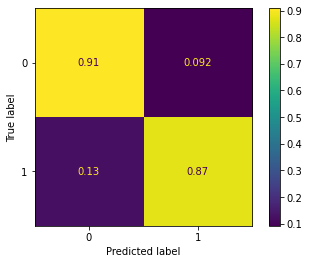

In [27]:
cm = confusion_matrix(y_ts.to_numpy(), y_pred, labels=mdl_final.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=mdl_final.classes_)
disp.plot()
plt.show()

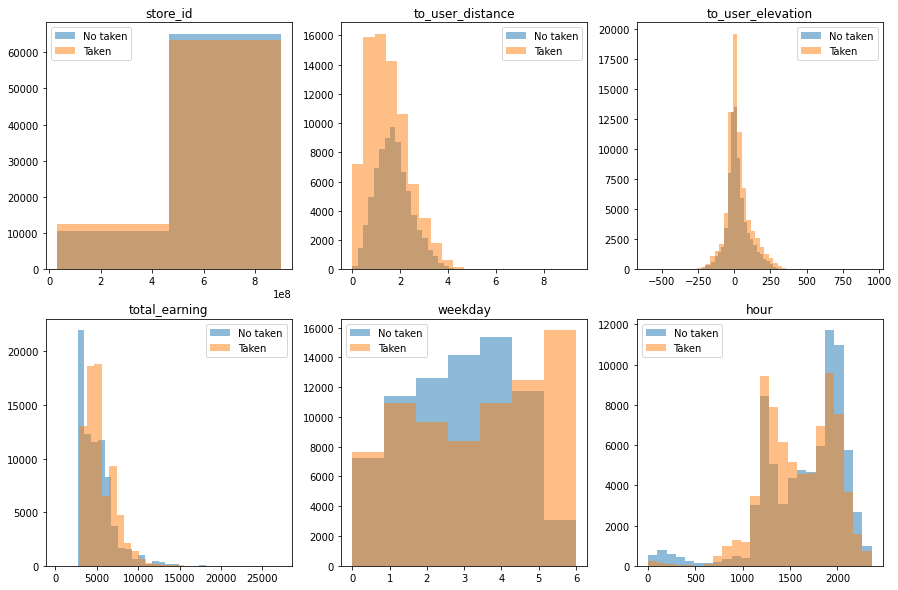

In [28]:
plt.figure(figsize=(15,10))
feat = list(X_tr.keys())
feat_bins = [2,20,50,30,7,24]
for i in range(len(feat)):
    plt.subplot(2,3,i+1)
    plt.hist(X_tr[feat[i]][y_tr==0],bins=feat_bins[i],alpha=0.5,label='No taken')
    plt.hist(X_tr[feat[i]][y_tr==1],bins=feat_bins[i],alpha=0.5,label='Taken')
    plt.legend()
    plt.title(feat[i])
plt.show()